<div align="center">

# Projet Séparation de Sources

### Adhémar de Senneville & Adib Habbou

</div>

## Importation

In [150]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

kaggle = True

train_mode_dumb = True
train_mode_waveunet = True
train_mode_convtasnet = True
train_mode_hdemucs = True

path_to_models = "/kaggle/input/reload-model/"

if kaggle:
    absolute_path = "/kaggle/input/thalesprojet/source_separation/"
    os.sys.path.append("/kaggle/input/thalesprojet")
    !pip install pesq pystoi mir_eval
else:
    absolute_path = ""
    path_to_models = "./"

In [145]:
from ProgressDBar import ProgressTrain

In [146]:
import glob
import mir_eval
import numpy as np
from scipy.io import wavfile
import IPython.display as ipd
import matplotlib.pyplot as plt
from scipy.signal import wiener, butter, filtfilt
from pesq import pesq
from pystoi import stoi
import pandas as pd
import pickle
from tabulate import tabulate

In [147]:
import torch
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
import torch.nn as nn
import torchaudio
from tqdm import tqdm
import torch.nn.functional as F

## Data Loading

In [148]:
def load_data(main_directory):
    voice_data = []
    noise_data = []
    mix_data = []
    
    for sub_directory in os.listdir(main_directory):
        sub_directory_path = os.path.join(main_directory, sub_directory)

        if os.path.isdir(sub_directory_path):
            wav_files = glob.glob(os.path.join(sub_directory_path, '*.wav'))

            for wav_file in wav_files:
                _, data = wavfile.read(wav_file)
                if 'voice.wav' in wav_file:
                    voice_data.append(data)
                elif 'noise.wav' in wav_file:
                    noise_data.append(data)
                elif 'mix_snr' in wav_file:
                    mix_data.append(data)

    voice_data = np.array(voice_data)
    noise_data = np.array(noise_data)
    mix_data = np.array(mix_data)

    return voice_data, noise_data, mix_data

In [151]:
train_small_voice, train_small_noise, train_small_mix = load_data(absolute_path + 'source_separation/train_small')
train_voice, train_noise, train_mix = load_data(absolute_path + 'source_separation/train')
test_voice, test_noise, test_mix = load_data(absolute_path + 'source_separation/test')

In [152]:
print('train_small_voice.shape: ', train_small_voice.shape)
print('train_small_noise.shape: ', train_small_noise.shape)
print('train_small_mix.shape: ', train_small_mix.shape)

train_small_voice.shape:  (50, 80000)
train_small_noise.shape:  (50, 80000)
train_small_mix.shape:  (50, 80000)


In [153]:
print('train_voice.shape: ', train_voice.shape)
print('train_noise.shape: ', train_noise.shape)
print('train_mix.shape: ', train_mix.shape)

train_voice.shape:  (5000, 80000)
train_noise.shape:  (5000, 80000)
train_mix.shape:  (5000, 80000)


In [154]:
print('test_voice.shape: ', test_voice.shape)
print('test_noise.shape: ', test_noise.shape)
print('test_mix.shape: ', test_mix.shape)

test_voice.shape:  (2000, 80000)
test_noise.shape:  (2000, 80000)
test_mix.shape:  (2000, 80000)


In [155]:
def listen_to_sample(wave):
    ipd.display(ipd.Audio(wave, rate=8000))

In [156]:
listen_to_sample(train_small_mix[0])

In [157]:
listen_to_sample(train_small_voice[0])

In [158]:
listen_to_sample(train_small_noise[0])

## Data Analysis

In [159]:
def plot_signals(mix, voice, noise, sampling_rate=8000):
    duration = len(mix) / sampling_rate
    time = np.linspace(0, duration, len(mix))
    
    _, axs = plt.subplots(3, 1, figsize=(20, 10))

    axs[0].plot(time, mix)
    axs[0].set_title('Mix')
    axs[0].set_xlabel('Time (s)')
    
    axs[1].plot(time, voice)
    axs[1].set_title('Voice')
    axs[1].set_xlabel('Time (s)')
    
    axs[2].plot(time, noise)
    axs[2].set_title('Noise')
    axs[2].set_xlabel('Time (s)')
    
    plt.tight_layout()
    plt.show()

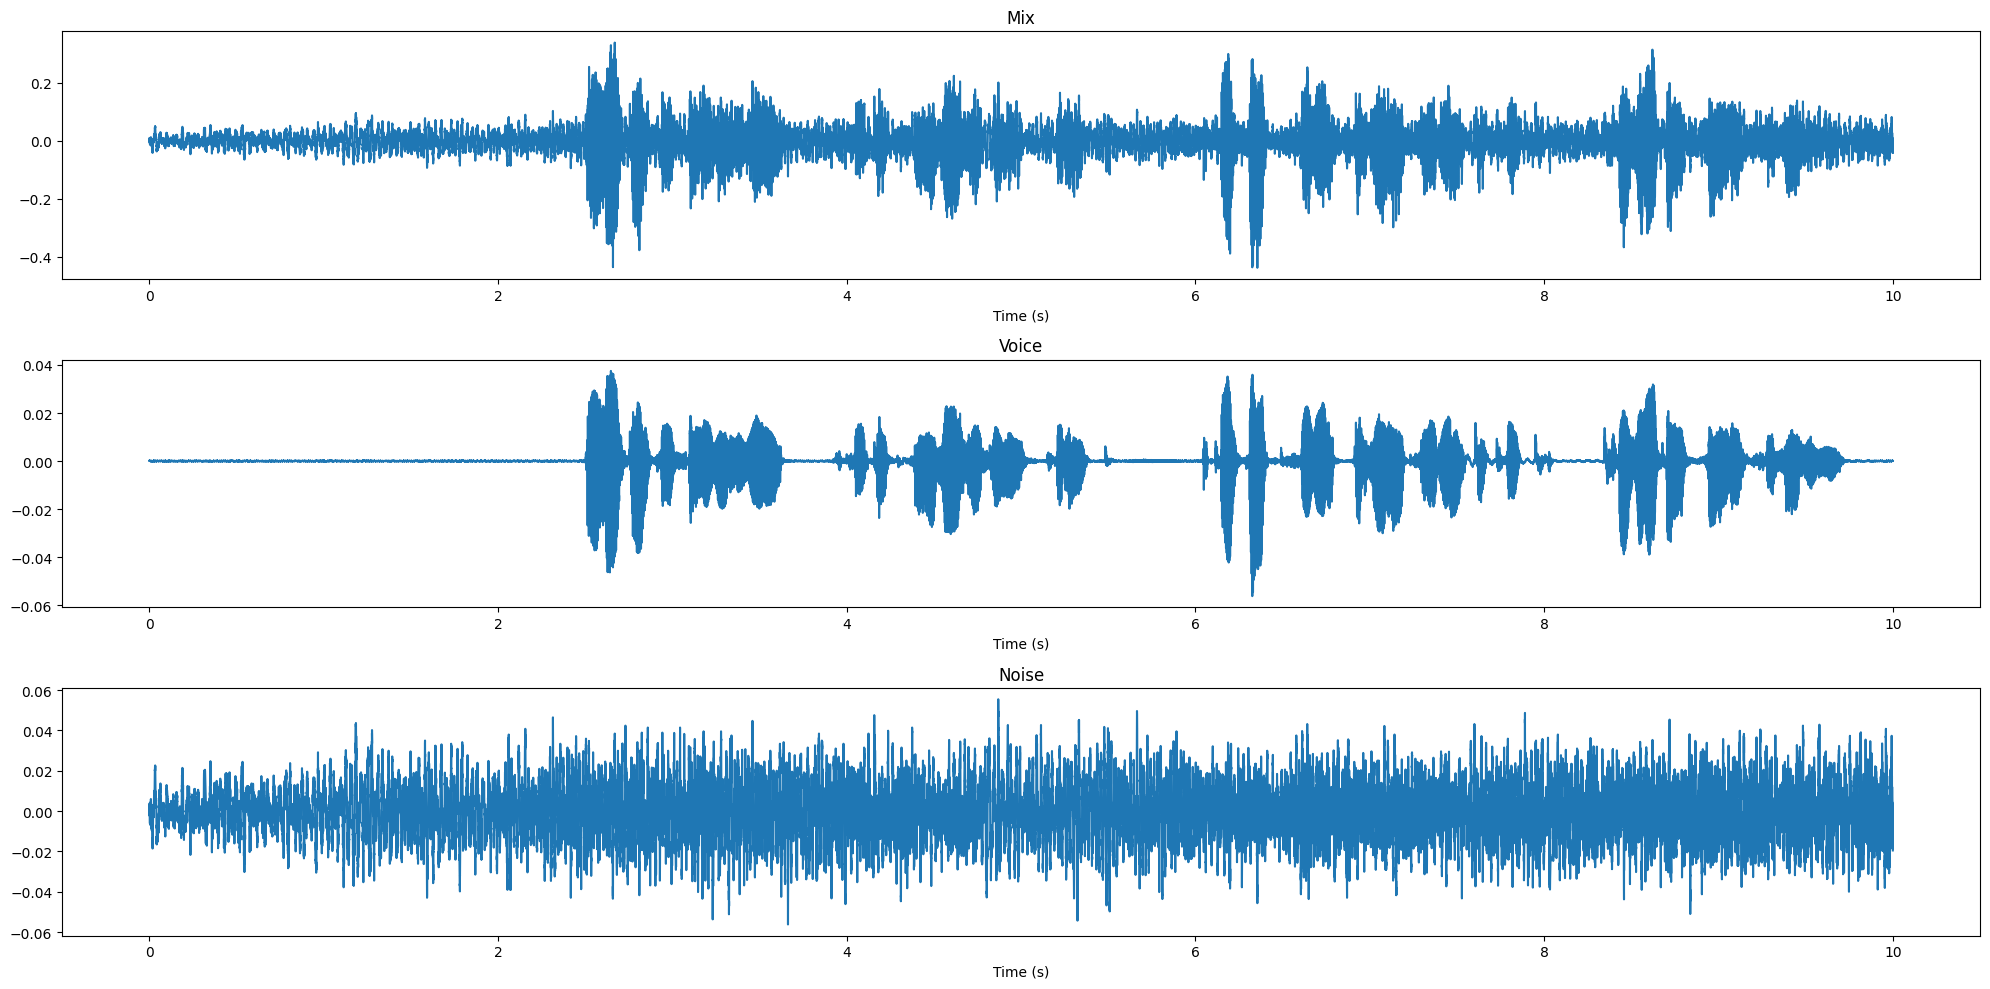

In [160]:
plot_signals(train_small_mix[0], train_small_voice[0], train_small_noise[0])

In [161]:
def plot_spectrogram(mix, voice, noise, sampling_rate=8000):
    _, axs = plt.subplots(3, 1, figsize=(20, 10))
    axs[0].specgram(mix, Fs=sampling_rate)
    axs[0].set_title('Mix')
    axs[0].set_xlabel('Time (s)')
    
    axs[1].specgram(voice, Fs=sampling_rate)
    axs[1].set_title('Voice')
    axs[1].set_xlabel('Time (s)')
    
    axs[2].specgram(noise, Fs=sampling_rate)
    axs[2].set_title('Noise')
    axs[2].set_xlabel('Time (s)')
    
    plt.tight_layout()
    plt.show()

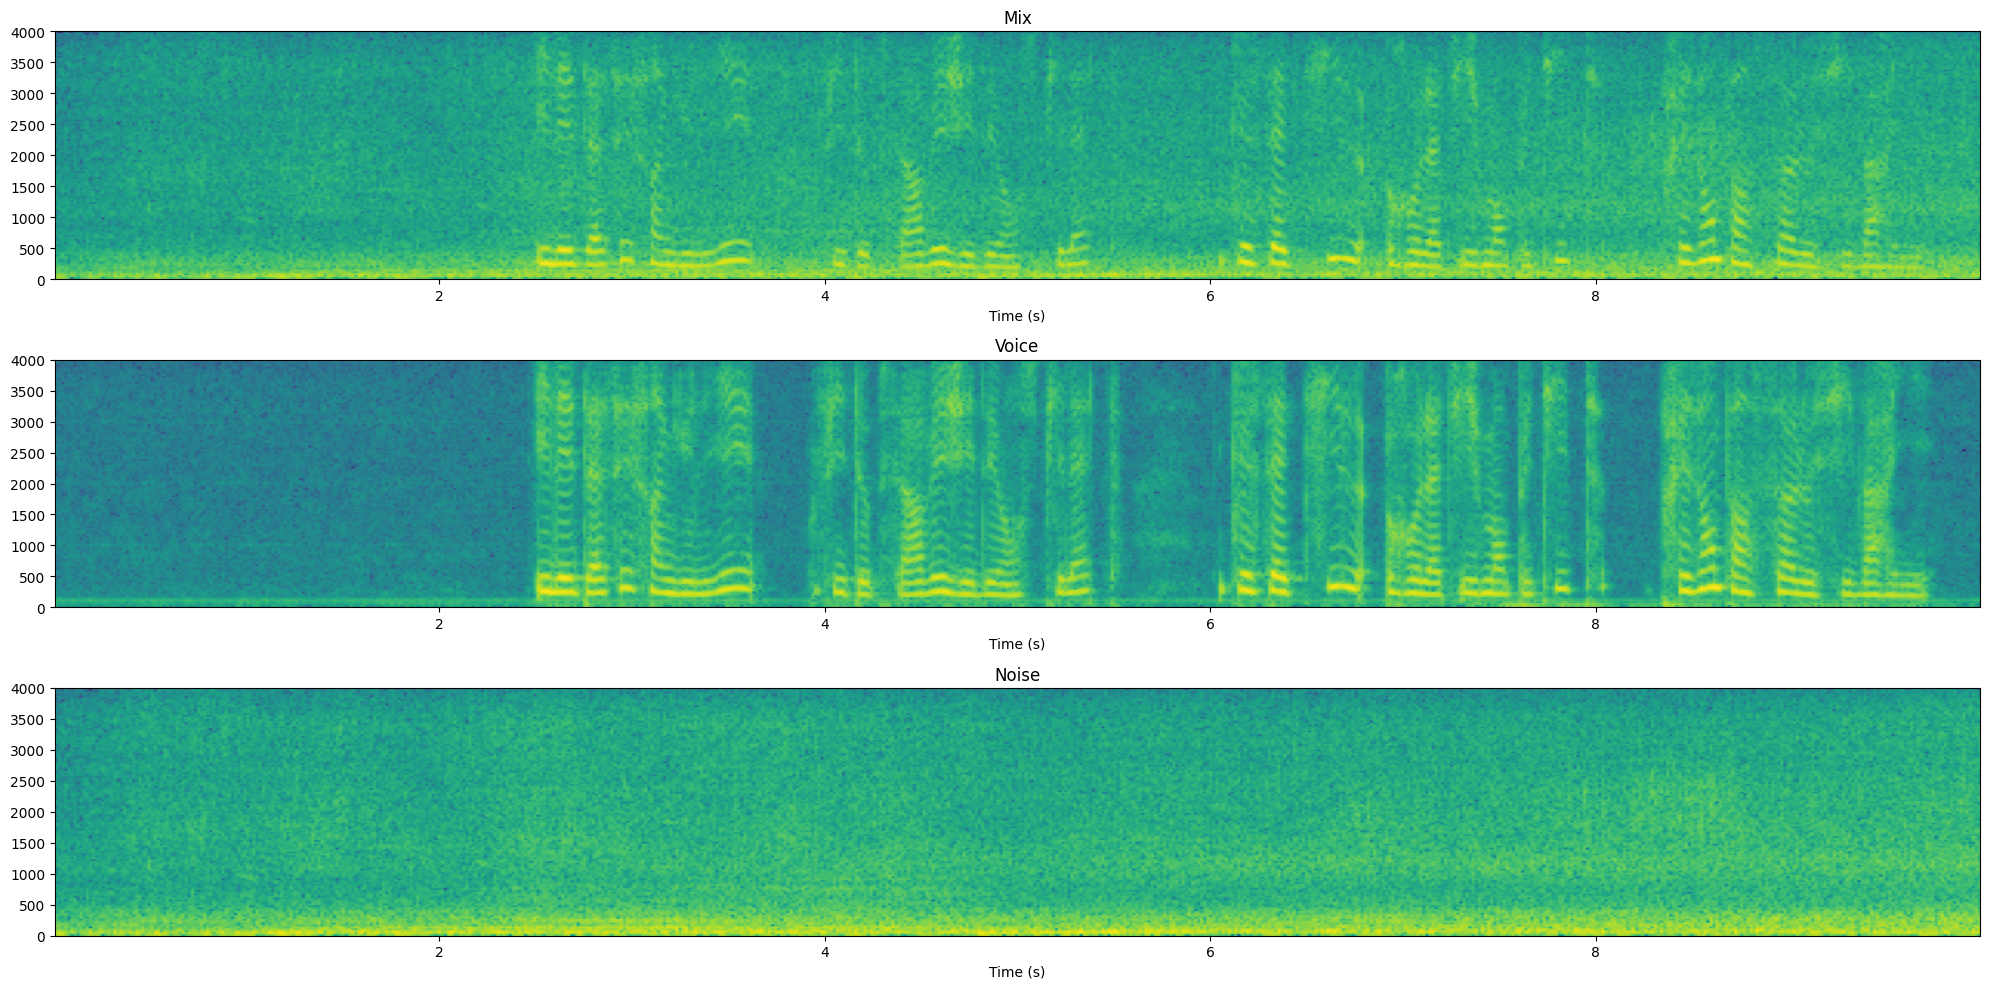

In [162]:
plot_spectrogram(train_small_mix[0], train_small_voice[0], train_small_noise[0])

In [163]:
def plot_fourier_transform(mix, voice, noise, sampling_rate=8000):
    _, axs = plt.subplots(3, 1, figsize=(20, 10))
    axs[0].magnitude_spectrum(mix, Fs=sampling_rate)
    axs[0].set_title('Mix')
    axs[0].set_xlabel('Frequency (Hz)')
    
    axs[1].magnitude_spectrum(voice, Fs=sampling_rate)
    axs[1].set_title('Voice')
    axs[1].set_xlabel('Frequency (Hz)')
    
    axs[2].magnitude_spectrum(noise, Fs=sampling_rate)
    axs[2].set_title('Noise')
    axs[2].set_xlabel('Frequency (Hz)')
    
    plt.tight_layout()
    plt.show()

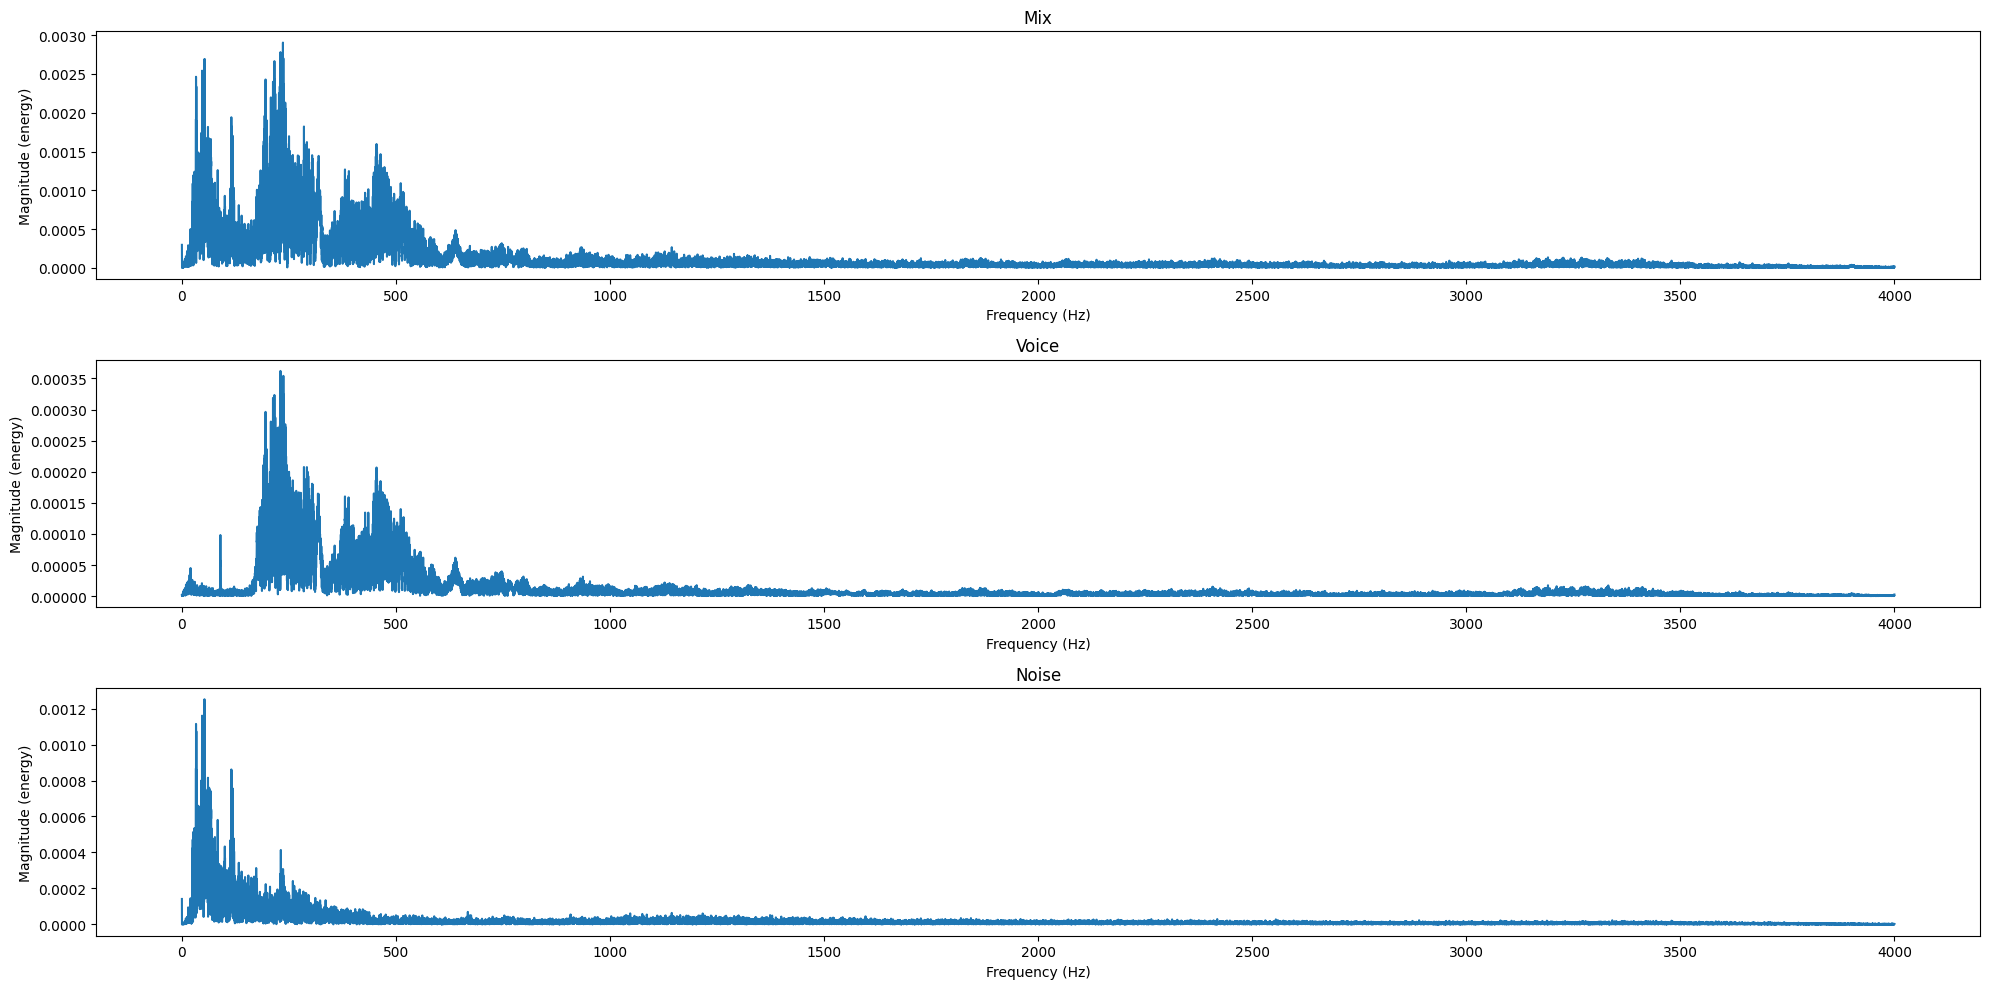

In [164]:
plot_fourier_transform(train_small_mix[0], train_small_voice[0], train_small_noise[0])

In [165]:
def plot_psd(mix, voice, noise, sampling_rate=8000):
    _, axs = plt.subplots(3, 1, figsize=(20, 10))
    axs[0].psd(mix, Fs=sampling_rate)
    axs[0].set_title('Mix')
    axs[0].set_xlabel('Frequency (Hz)')
    
    axs[1].psd(voice, Fs=sampling_rate)
    axs[1].set_title('Voice')
    axs[1].set_xlabel('Frequency (Hz)')
    
    axs[2].psd(noise, Fs=sampling_rate)
    axs[2].set_title('Noise')
    axs[2].set_xlabel('Frequency (Hz)')
    
    plt.tight_layout()
    plt.show()

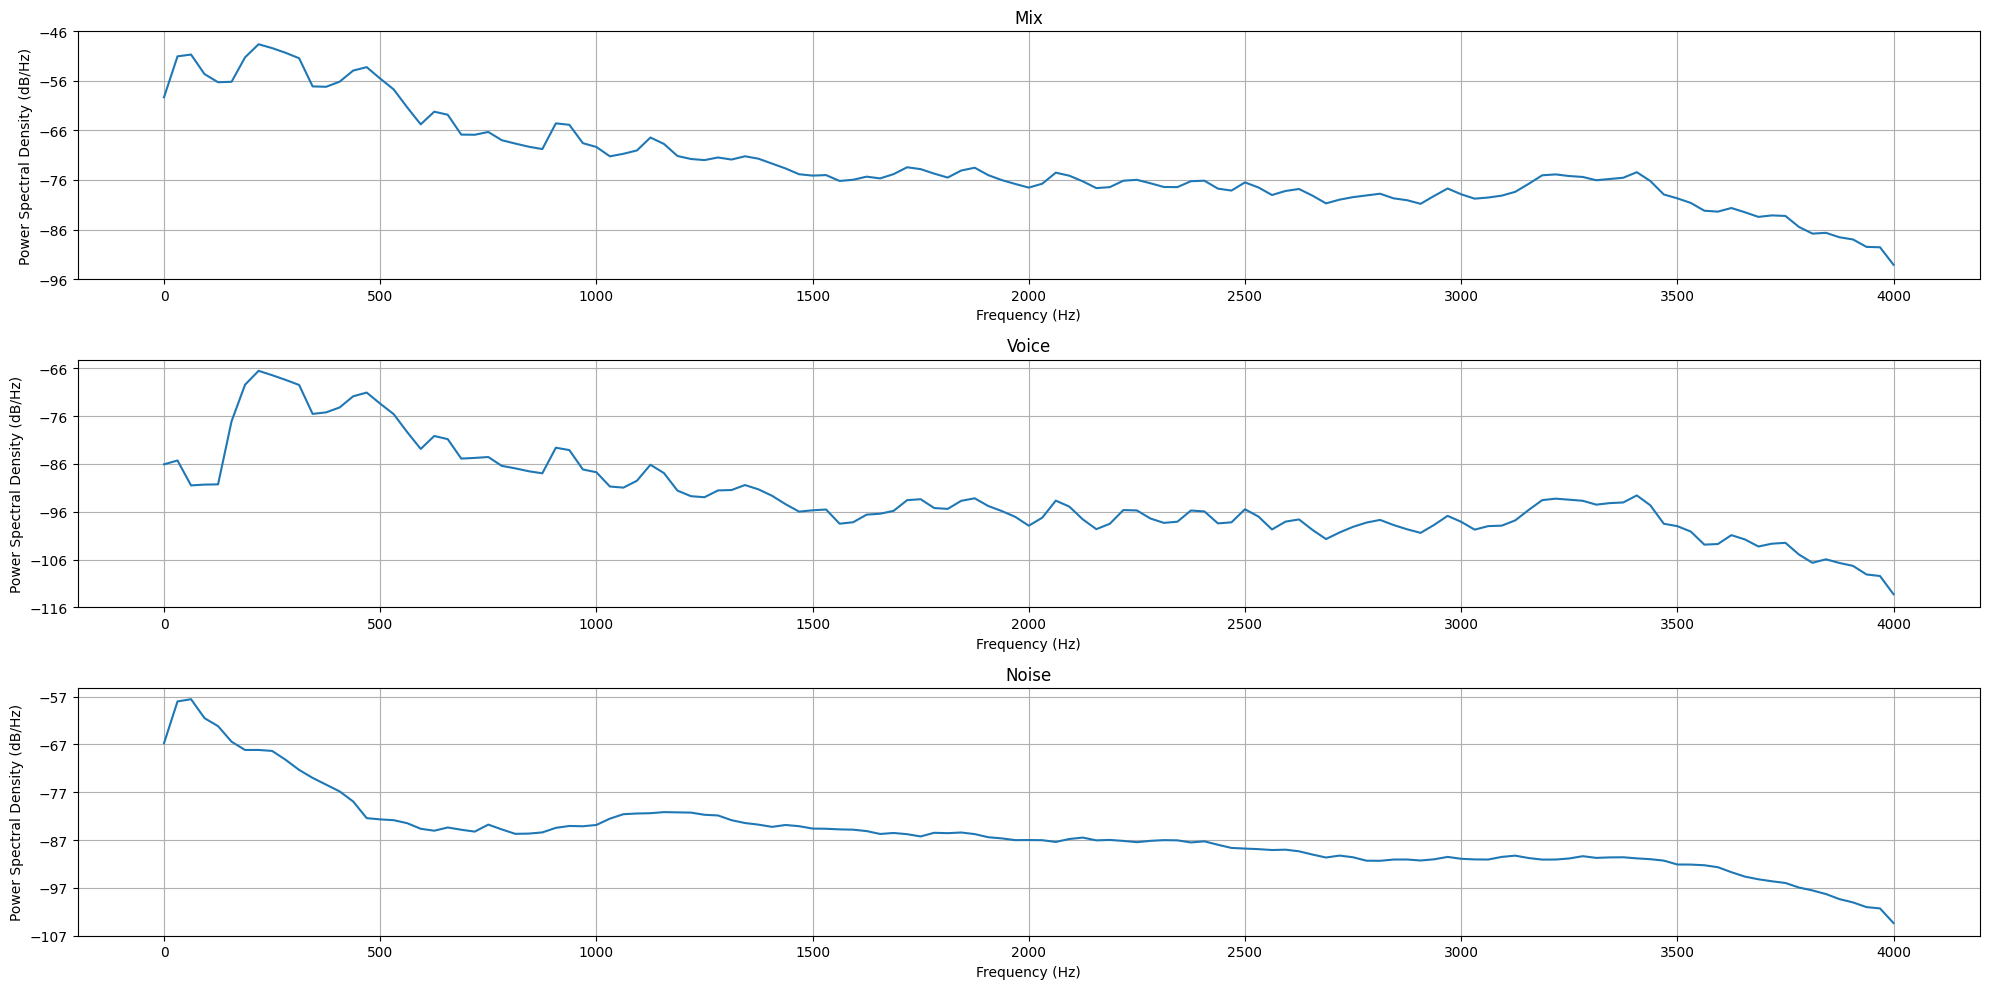

In [166]:
plot_psd(train_small_mix[0], train_small_voice[0], train_small_noise[0])

## Evaluation Metrics

### Signal to Distortion Ratio (SDR )

In [167]:
def compute_sdr(mix, voice, noise):
    target = np.dot(mix, voice) / np.dot(voice, voice)
    SDR = 10 * np.log10(np.sum(target ** 2) / np.sum(noise ** 2))
    return round(SDR, 2)

$$\text{target} = \frac{\text{mix} \cdot \text{voice}}{\text{voice} \cdot \text{voice}}$$

$$\text{SDR} = 10 \cdot \log_{10} \left( \frac{{\sum_i \text{target}[i]^2}}{{\sum_i \text{noise}[i]^2}} \right)$$

In [168]:
compute_sdr(train_small_mix[0], train_small_voice[0], train_small_noise[0])

6.0

### Perceptual Evaluation of Speech Quality (PESQ)

In [169]:
def compute_pesq(degraded_signal, reference_signal, sampling_rate=8000):
    pesq_score = pesq(sampling_rate, reference_signal, degraded_signal, mode='nb')
    return round(pesq_score, 2)

PESQ est un algorithme qui évalue la différence de qualité perçue entre un signal vocal dégradé et une référence, visant à simuler la perception auditive humaine.

In [170]:
compute_pesq(train_small_mix[0], train_small_voice[0])

1.72

### Short-Time Objective Intelligibility (STOI)

In [171]:
def compute_stoi(degraded_signal, reference_signal, sampling_rate=8000):
    stoi_score = stoi(reference_signal, degraded_signal, sampling_rate)
    return round(stoi_score, 2)

STOI est un algorithme qui mesure la compréhensibilité de la parole dans un signal dégradé.

In [172]:
compute_stoi(train_small_mix[0], train_small_voice[0])

0.89

### General Evaluation

In [173]:
def compute_metrics(mix, estimated_voice, estimated_noise):
    sdr = compute_sdr(mix, estimated_voice, estimated_noise)
    pesq_score = compute_pesq(mix, estimated_voice)
    stoi_score = compute_stoi(mix, estimated_voice)
    return sdr, pesq_score, stoi_score

In [181]:
def test_pipeline_0(model):
    

    all_losses = []
    all_sdr_scores = []
    all_pesq_scores = []
    all_stoi_scores = []
    
    test_voice , test_noise , test_mix

    
    with tqdm(total=len(test_mix), desc='Testing', unit='Sample') as pbar_test:
        for voice , noise , mix in zip(test_voice , test_noise , test_mix):

            estimated_voice, estimated_noise = model(mix)

            loss = np.linalg.norm(estimated_voice - voice) + np.linalg.norm(estimated_noise - noise)
            all_losses.append(loss.item()/len(mix))
                
            sdr = compute_sdr(mix, estimated_voice, estimated_noise)
            try:
                pesq = compute_pesq(mix.flatten(), estimated_voice.flatten())
            except:
                pesq = 0
            stoi = compute_stoi(mix, estimated_voice)

            all_sdr_scores.append(sdr)
            all_pesq_scores.append(pesq)
            all_stoi_scores.append(stoi)

            pbar_test.update(1)
            pbar_test.set_postfix(test_loss=f'{loss.item():.4f}', SDR=f'{sdr:.4f}', PESQ=f'{pesq:.4f}', STOI=f'{stoi:.4f}')

    avg_loss = np.mean(all_losses)
    avg_sdr = np.mean(all_sdr_scores)
    avg_pesq = np.mean(all_pesq_scores)
    avg_stoi = np.mean(all_stoi_scores)

    print(f'Test Results: Loss: {avg_loss:.4f} | SDR: {avg_sdr:.4f} | PESQ: {avg_pesq:.4f} | STOI: {avg_stoi:.4f}')
    return {"MSE Loss" : avg_loss,
           "SDR" : avg_sdr,
           "PESQ" : avg_pesq,
           "STOI" : avg_stoi}

In [174]:
all_metrics = {}

## Base Models (Dumb Filters)

### Wiener Filter

$$x_{wiener}(n) = \sum_{m=0}^{M} h(m) \cdot \left[ x(n-m) - \mu_x(n) \right] + \mu_x(n)$$

\begin{align*}
&x_{wiener}(n) \text{ : valeur estimée du signal au temps } n\
&x(n) \text{ : signal d'entrée au temps } n\\
&h(m) \text{ : coefficients du filtre de Wiener}\
&\mu_x(n) \text{ : moyenne locale du signal d'entrée au temps } n
\end{align*}

In [175]:
def wiener_filter(mixed_signal):
    voice_signal = wiener(mixed_signal, mysize=10)
    noise_signal = mixed_signal - voice_signal
    return voice_signal, noise_signal

In [176]:
voice_weiner, noise_weiner = wiener_filter(train_small_mix[0])
listen_to_sample(train_small_mix[0])
listen_to_sample(voice_weiner)
listen_to_sample(noise_weiner)

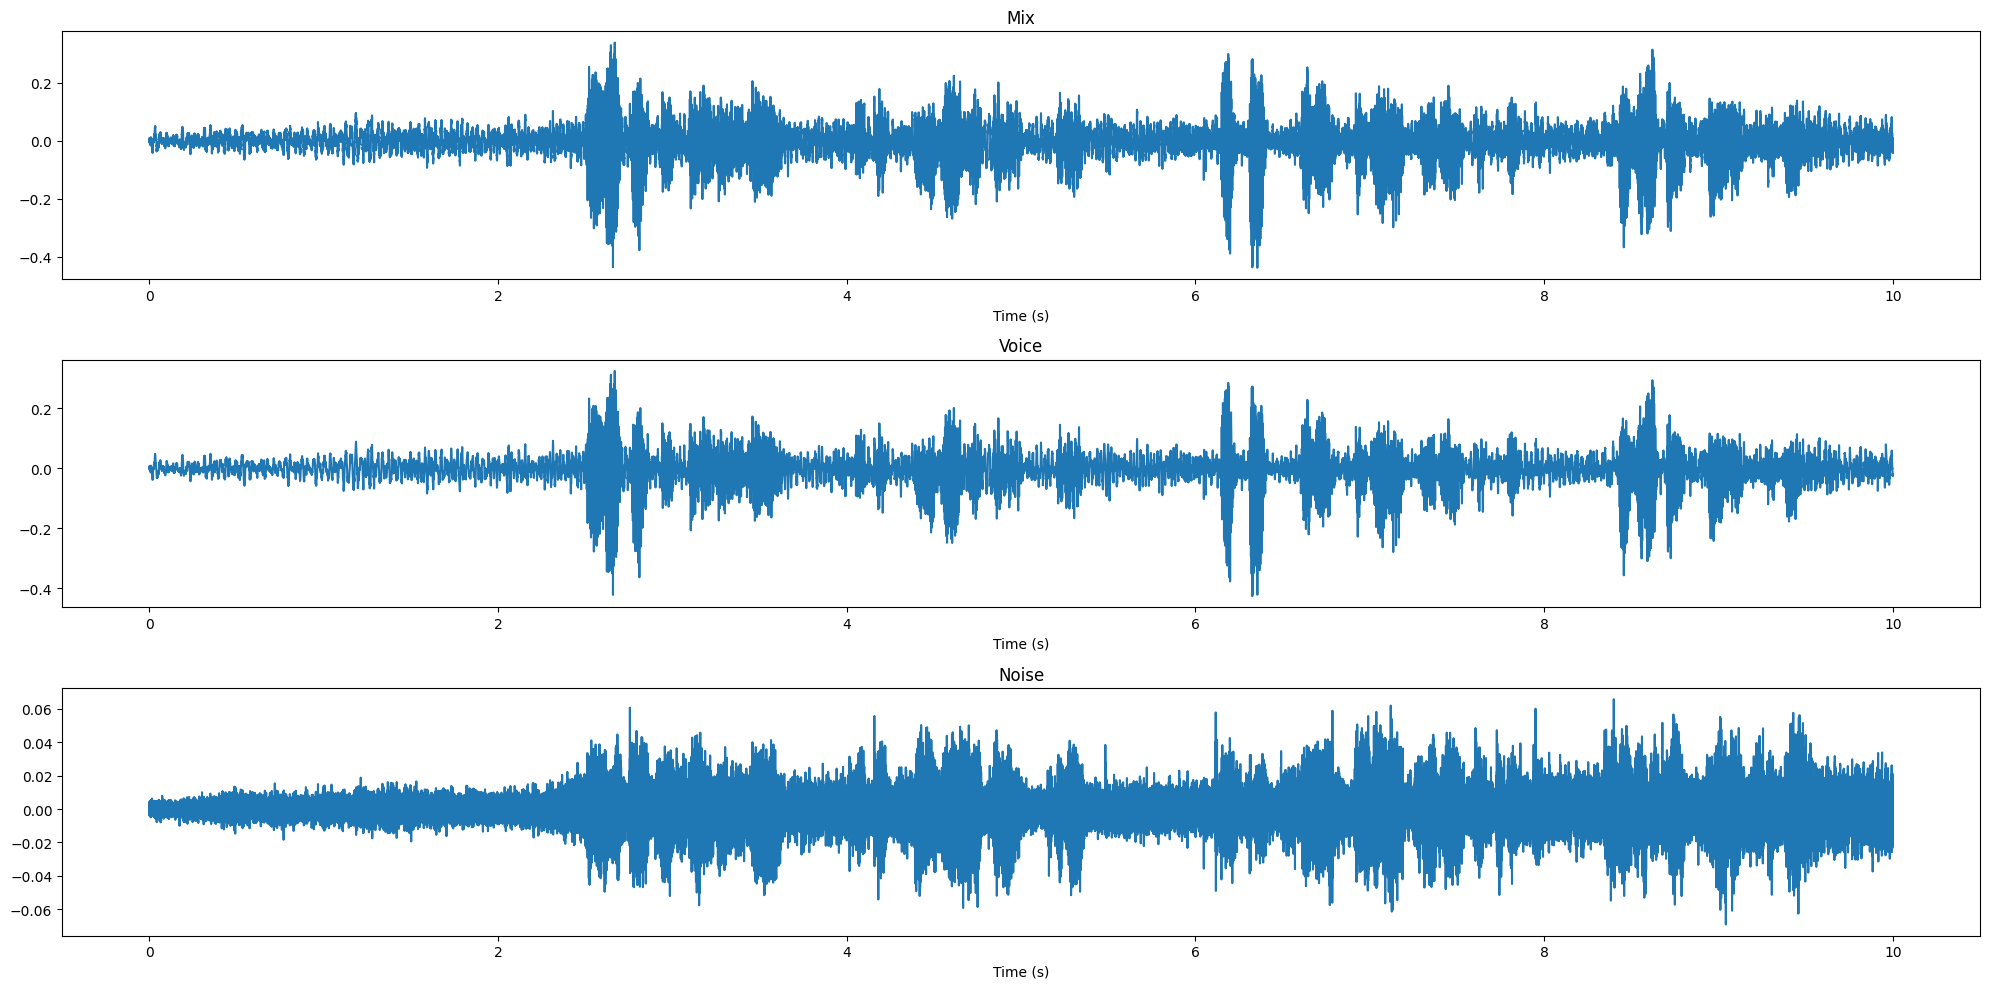

In [177]:
plot_signals(train_small_mix[0], voice_weiner, noise_weiner)

In [182]:
all_metrics['Wiener Filter'] = test_pipeline_0(wiener_filter)

Testing: 100%|██████████| 2000/2000 [09:24<00:00,  3.54Sample/s, PESQ=2.0200, SDR=-9.0200, STOI=0.8100, test_loss=17.2201] 

Test Results: Loss: 0.0002 | SDR: -10.6569 | PESQ: 2.0880 | STOI: 0.8040


In [183]:
all_metrics['Wiener Filter']["Number of Parameters"] = 1

start_time = time.time()
voice_weiner, noise_weiner = wiener_filter(train_small_mix[0])
end_time = time.time()
all_metrics['Wiener Filter']["Inference Time"] = end_time - start_time

all_metrics['Wiener Filter']

{'MSE Loss': 0.00021820614310045372,
 'SDR': -10.656889999999999,
 'PESQ': 2.08805,
 'STOI': 0.8039700000000001,
 'Number of Parameters': 1,
 'Inference Time': 0.005758047103881836}

### Butterworth Filter

$$H(\omega) = \frac{1}{{\sqrt{1 + \left(\frac{\omega}{{\omega_c}}\right)^{2N}}}}$$

\begin{align*}
    &H(\omega) \text{ : réponse en fréquence du filtre de Butterworth}\
    &\omega \text{ : fréquence}\
    &\omega_c \text{ : fréquence de coupure}\
    &N \text{ : ordre}
\end{align*}

$$\omega = \frac{2}{T} \frac{z - 1}{z + 1}$$

\begin{align*}
    &a(z) = \sum_{k=0}^{N} a_k z^{-k}\
    &b(z) = \sum_{k=0}^{M} b_k z^{-k}
\end{align*}

$$y(n) = \sum_{k=0}^{M} b(k) \cdot x(n-k) - \sum_{k=1}^{N} a(k) \cdot y(n-k)$$

\begin{align*}
&y(n) \text{ est le signal de sortie à l'échantillon } n\
&x(n) \text{ est le signal d'entrée à l'échantillon } n\
&b(k) \text{ et } a(k) \text{ sont les coefficients du filtre}\
\end{align*}

In [184]:
def butterworth_filter(mixed_signal, cutoff_freq=2000, fs=8000, order=4, btype='low'):
    nyquist_freq = 0.5 * fs
    normal_cutoff = cutoff_freq / nyquist_freq
    b, a = butter(order, normal_cutoff, btype=btype, analog=False)
    voice_signal = filtfilt(b, a, mixed_signal)
    noise_signal = mixed_signal - voice_signal
    return voice_signal, noise_signal

In [185]:
voice_butterworth, noise_butterworth = butterworth_filter(train_small_mix[0])
listen_to_sample(train_small_mix[0])
listen_to_sample(voice_butterworth)
listen_to_sample(noise_butterworth)

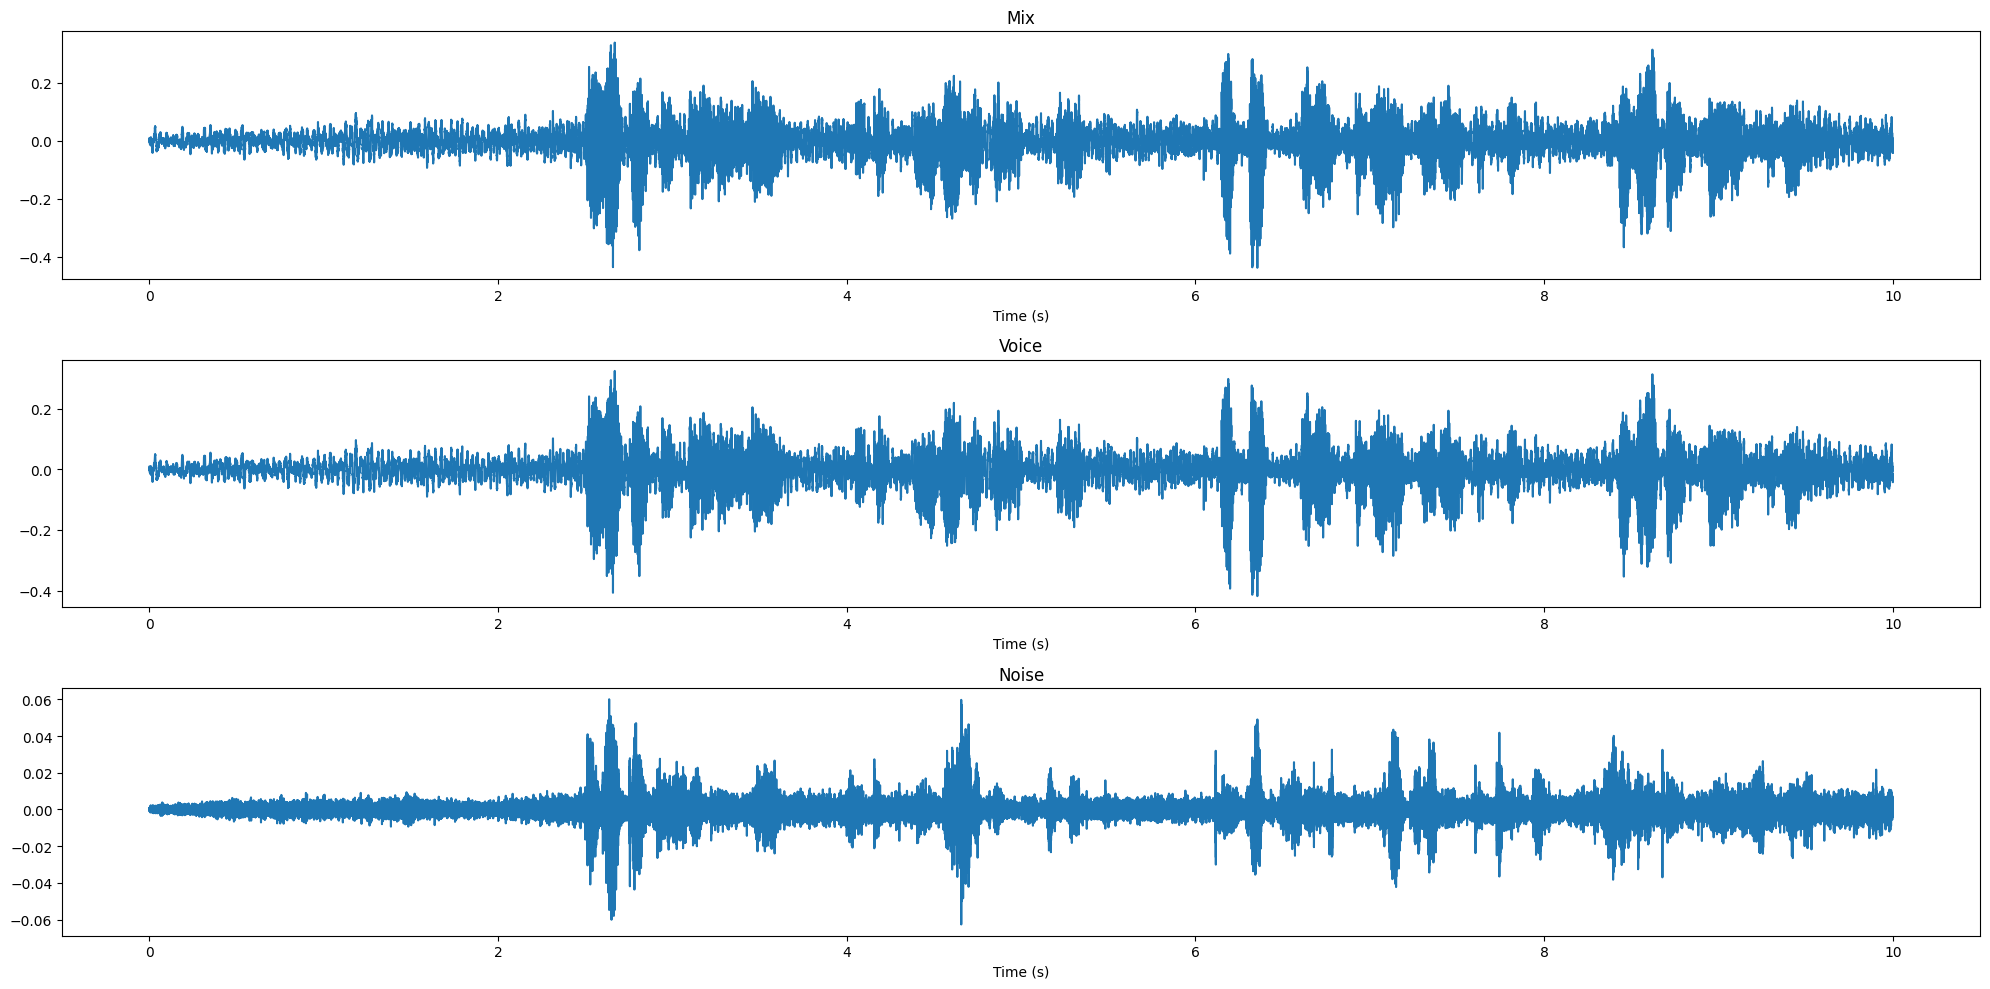

In [186]:
plot_signals(train_small_mix[0], voice_butterworth, noise_butterworth)

In [187]:
all_metrics['Butterworth Filter'] = test_pipeline_0(butterworth_filter)

Testing: 100%|██████████| 2000/2000 [08:55<00:00,  3.73Sample/s, PESQ=1.7700, SDR=0.0000, STOI=0.9100, test_loss=17.5992]  

Test Results: Loss: 0.0002 | SDR: -3.7573 | PESQ: 1.5780 | STOI: 0.8957


In [189]:
all_metrics['Butterworth Filter']["Number of Parameters"] = 4

start_time = time.time()
voice_butterworth, noise_butterworth = butterworth_filter(train_small_mix[0])
end_time = time.time()
all_metrics['Butterworth Filter']["Inference Time"] = end_time - start_time
all_metrics['Butterworth Filter']

{'MSE Loss': 0.0002229550116029258,
 'SDR': -3.757295,
 'PESQ': 1.57805,
 'STOI': 0.8957250000000002,
 'Number of Parameters': 4,
 'Inference Time': 0.00489497184753418}

## Deep Learning Models

### Dataset

In [40]:
class AudioDataset(Dataset):
    def __init__(self, main_directory, voice_data, noise_data, mix_data):
        if main_directory == False:
            self.voice_data, self.noise_data, self.mix_data = voice_data, noise_data, mix_data
        else:
            self.voice_data, self.noise_data, self.mix_data = self.load_data(main_directory)

    def __len__(self):
        return len(self.mix_data)

    def __getitem__(self, idx):
        return {
            'mixed': torch.from_numpy(self.mix_data[idx]).unsqueeze(0),
            'voice': torch.from_numpy(self.voice_data[idx]).unsqueeze(0),
            'noise': torch.from_numpy(self.noise_data[idx]).unsqueeze(0)
        }

    @staticmethod
    def load_data(main_directory):
        voice_data = []
        noise_data = []
        mix_data = []

        for sub_directory in os.listdir(main_directory):
            sub_directory_path = os.path.join(main_directory, sub_directory)

            if os.path.isdir(sub_directory_path):
                wav_files = glob.glob(os.path.join(sub_directory_path, '*.wav'))

                for wav_file in wav_files:
                    _, data = wavfile.read(wav_file)
                    if 'voice.wav' in wav_file:
                        voice_data.append(data)
                    elif 'noise.wav' in wav_file:
                        noise_data.append(data)
                    elif 'mix_snr' in wav_file:
                        mix_data.append(data)

        voice_data = np.array(voice_data)
        noise_data = np.array(noise_data)
        mix_data = np.array(mix_data)

        return voice_data, noise_data, mix_data

In [41]:
train_dataset = AudioDataset(False, train_voice, train_noise, train_mix)
test_dataset = AudioDataset(False, test_voice, test_noise, test_mix)

In [42]:
train_loader = DataLoader(train_dataset, batch_size=10, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=10, shuffle=False)

### Pipeline

In [43]:
def train_pipeline(model, train_loader, criterion, device, optimizer, n_epochs):
    for epoch in range(n_epochs):

        model.train()

        with tqdm(total=len(train_loader), desc=f'Epoch {epoch + 1}/{n_epochs}', unit='batch') as pbar_train:
            for _, data in enumerate(train_loader):
                mixed, voice, _ = data['mixed'].to(device), data['voice'].to(device), data['noise'].to(device)

                optimizer.zero_grad()
                estimated_voice, estimated_noise = model(mixed)

                loss = criterion(estimated_voice, voice)
                loss.backward()
                optimizer.step()

                pbar_train.update(1)
                pbar_train.set_postfix(train_loss=f'{loss.item():.4f}')


def evaluate_audio_separation(ref_audio, est_audio, fs = 8000):
    if isinstance(ref_audio, torch.Tensor):
        ref_audio = ref_audio.numpy()
    if isinstance(est_audio, torch.Tensor):
        est_audio = est_audio.numpy()


    if len(ref_audio.shape) == 1:
        ref_audio = np.expand_dims(ref_audio, axis=0)
        est_audio = np.expand_dims(est_audio, axis=0)

    sdr, sir, sar, _ = mir_eval.separation.bss_eval_sources(ref_audio, est_audio)

    pesq_score = []
    for ref, est in zip(ref_audio, est_audio):
        score = pesq(fs, ref, est, 'nb')
        pesq_score.append(score)

    stoi_score = []
    for ref, est in zip(ref_audio, est_audio):
        score = stoi(ref, est, fs, extended=False) 
        stoi_score.append(score)

    return {
        "SDR": np.mean(sdr),
        "SIR": np.mean(sir),
        "SAR": np.mean(sar),
        "PESQ": np.mean(np.array(pesq_score)),
        "STOI": np.mean(np.array(stoi_score))
    }

class EarlyStopping:
    def __init__(self, patience=2):
        self.patience = patience
        self.counter = 0
        self.best_score = None
        self.early_stop = False

    def __call__(self, val_accuracy):
        score = val_accuracy

        if self.best_score is None:
            self.best_score = score
        elif score >= self.best_score:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.counter = 0


def TRAIN(model, criterion, device, optimizer, num_epochs, save_model):
    try:
        es = EarlyStopping()
        P = ProgressTrain(len(train_loader),names = ["Batch Loss"], epoch_names = []) #,epoch_names = ["SDR","PESQ","STOI"]
        loss_hist = []
        for epoch in range(num_epochs):

            model.train()

            for batch in train_loader:

                mixed = batch['mixed'].to(device)
                voice = batch['voice'].to(device)
                noise = batch['noise'].to(device)

                optimizer.zero_grad()
                voice_est, noise_est = model(mixed)
                loss = criterion(voice_est, voice) + criterion(noise_est, noise)
                loss.backward()
                optimizer.step()

                loss_hist.append(loss.item())

                P.update([loss.item()])


            model.eval()
            with torch.no_grad():
                total_loss_valid = 0
                for batch in test_loader:

                    mixed = batch['mixed'].to(device)
                    voice = batch['voice'].to(device)
                    noise = batch['noise'].to(device)

                    voice_est, noise_est = model(mixed)
                    loss = criterion(voice_est, voice) + criterion(noise_est, noise)
                    total_loss_valid += loss.item()

            mean_loss_train = np.sum(np.array(loss_hist)[-len(train_loader):])/len(train_loader)
            mean_loss_valid = total_loss_valid/len(test_loader)

            P.end([mean_loss_train,mean_loss_valid]) #,metrics["SDR"],metrics["PESQ"],metrics["STOI"]

            es(mean_loss_valid)

            if es.best_score == mean_loss_valid:
                torch.save(model, save_model)

            if es.early_stop:
                print("Early stopping triggered")
                break

        P.plot()
            
    except KeyboardInterrupt:
        torch.save(model, save_model)
        print("Training interrupted and model saved.")
        P.plot()

In [44]:
def test_pipeline(model, test_loader, criterion, device):
    model.eval()

    all_losses = []
    all_sdr_scores = []
    all_pesq_scores = []
    all_stoi_scores = []

    with torch.no_grad():
        with tqdm(total=len(test_loader), desc='Testing', unit='batch') as pbar_test:
            for _, data in enumerate(test_loader):
                mixed, voice, _ = data['mixed'].to(device), data['voice'].to(device), data['noise'].to(device)

                estimated_voice, estimated_noise = model(mixed)

                loss = criterion(estimated_voice, voice)
                all_losses.append(loss.item())

                for i in range(len(mixed)):
                    sdr = compute_sdr(mixed[i].squeeze().cpu().numpy(), estimated_voice[i].squeeze().cpu().detach().numpy(), estimated_noise[i].squeeze().cpu().detach().numpy())
                    try:
                        pesq = compute_pesq(mixed[i].squeeze().cpu().numpy().flatten(), estimated_voice[i].squeeze().cpu().detach().numpy().flatten())
                    except:
                        pesq = 0
                    stoi = compute_stoi(mixed[i].squeeze().cpu().numpy(), estimated_voice[i].squeeze().cpu().detach().numpy())

                    all_sdr_scores.append(sdr)
                    all_pesq_scores.append(pesq)
                    all_stoi_scores.append(stoi)

                pbar_test.update(1)
                pbar_test.set_postfix(test_loss=f'{loss.item():.4f}', SDR=f'{sdr:.4f}', PESQ=f'{pesq:.4f}', STOI=f'{stoi:.4f}')

    avg_loss = np.mean(all_losses)
    avg_sdr = np.mean(all_sdr_scores)
    avg_pesq = np.mean(all_pesq_scores)
    avg_stoi = np.mean(all_stoi_scores)

    print(f'Test Results: Loss: {avg_loss:.4f} | SDR: {avg_sdr:.4f} | PESQ: {avg_pesq:.4f} | STOI: {avg_stoi:.4f}')
    return {"MSE Loss" : avg_loss,
           "SDR" : avg_sdr,
           "PESQ" : avg_pesq,
           "PESQ" : avg_stoi}

### Dumb Model to test the pipeline

In [45]:
class DumbModel(nn.Module):
    def __init__(self):
        super(DumbModel, self).__init__()
        self.fc1 = nn.Linear(80000, 2)
        self.fc2 = nn.Linear(2, 80000)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x, x

In [46]:
model_dumb = DumbModel()

input_mix = torch.randn(3, 1, 80000, requires_grad=True)
output = model_dumb(input_mix)
print("Input  :",input_mix.shape)
print("Output :",len(output),output[0].shape,output[1].shape)

Input  : torch.Size([3, 1, 80000])

Output : 2 torch.Size([3, 1, 80000]) torch.Size([3, 1, 80000])


In [47]:
model = DumbModel()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = torch.nn.MSELoss()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
n_epochs = 5
save_model = 'dumb_model.pt'
model = model.to(device)

In [48]:
print(f'Number of parameters: {sum(p.numel() for p in model.parameters())}')

Number of parameters: 400002


[--------------------------------------------------]  0.00% ||   00h00m00s    ||   

------------------------------------------------------------|| Remaining Time || Batch Loss || 

||----||   Epoch   ||          Loss          || 

||----||   Time    ||   Train   ||   Test    || 

||  1 || 00h00m06s || 0.1474405 || 0.0567762 || 

||  2 || 00h00m04s || 0.0151698 || 0.0188430 || 

||  3 || 00h00m04s || 0.0010923 || 0.0156004 || 

||  4 || 00h00m04s || 0.0001901 || 0.0158063 || 

||  5 || 00h00m04s || 0.0001684 || 0.0158313 || 

Early stopping triggered


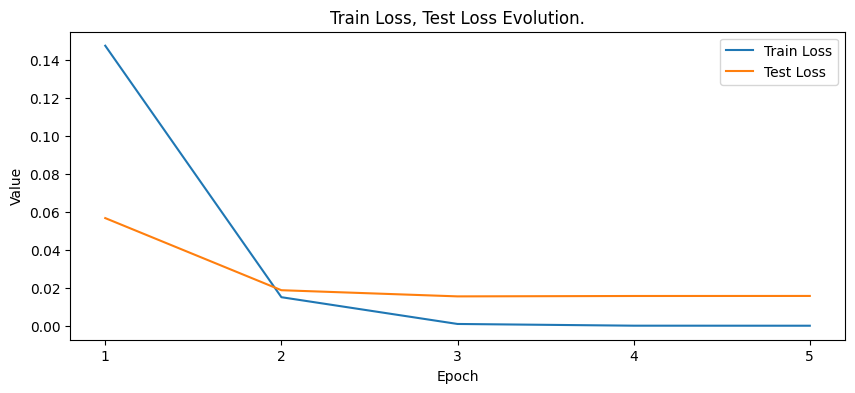

In [49]:
#train_pipeline(model, train_loader, criterion, device, optimizer, n_epochs)
if kaggle and train_mode_dumb:
    TRAIN(model, criterion, device, optimizer, n_epochs, save_model)
else:
    model = torch.load(path_to_models + save_model)

In [50]:
all_metrics["Dumb Model"] = test_pipeline(model, test_loader, criterion, device)

Testing: 100%|██████████| 200/200 [11:26<00:00,  3.43s/batch, PESQ=1.2400, SDR=-55.7900, STOI=0.0000, test_loss=0.0010]  

Test Results: Loss: 0.0079 | SDR: -25.9476 | PESQ: 1.2167 | STOI: 0.0024


In [51]:
num_parameters = sum(p.numel() for p in model.parameters() if p.requires_grad)
all_metrics["Dumb Model"]["Number of Parameters"] = num_parameters

dummy_input = torch.randn([1, 1, 80000]).to(device)
model.eval()
with torch.no_grad():
    start_time = time.time()
    _ = model(dummy_input)
    end_time = time.time()

all_metrics["Dumb Model"]["Inference Time"] = end_time - start_time

with open('model_metrics.pkl', 'wb') as file:
    pickle.dump(all_metrics, file)

### WaVE-U-Net

<div style="text-align:center">
    <img src="images/waveunet.png" alt="Wave-U-Net Architecture" width="600"/>
</div>


Combine des couches de convolution et d'upsampling/downsampling pour séparer les sources audio en utilisant des connexions "skip" pour préserver les détails lors de la reconstruction.

In [52]:
class DownSamplingLayer(nn.Module):
    def __init__(self, channel_in, channel_out, dilation=1, kernel_size=15, stride=1, padding=7):
        super(DownSamplingLayer, self).__init__()
        self.main = nn.Sequential(
            nn.Conv1d(channel_in, channel_out, kernel_size=kernel_size,
                      stride=stride, padding=padding, dilation=dilation),
            nn.BatchNorm1d(channel_out),
            nn.LeakyReLU(negative_slope=0.1)
        )

    def forward(self, ipt):
        return self.main(ipt)

class UpSamplingLayer(nn.Module):
    def __init__(self, channel_in, channel_out, kernel_size=5, stride=1, padding=2):
        super(UpSamplingLayer, self).__init__()
        self.main = nn.Sequential(
            nn.Conv1d(channel_in, channel_out, kernel_size=kernel_size,
                      stride=stride, padding=padding),
            nn.BatchNorm1d(channel_out),
            nn.LeakyReLU(negative_slope=0.1, inplace=True),
        )

    def forward(self, ipt):
        return self.main(ipt)

class Waveunet(nn.Module):
    def __init__(self, n_layers=12, channels_interval=24):
        super(Waveunet, self).__init__()

        self.n_layers = n_layers
        self.channels_interval = channels_interval
        encoder_in_channels_list = [1] + [i * self.channels_interval for i in range(1, self.n_layers)]
        encoder_out_channels_list = [i * self.channels_interval for i in range(1, self.n_layers + 1)]

        self.encoder = nn.ModuleList()
        for i in range(self.n_layers):
            self.encoder.append(
                DownSamplingLayer(
                    channel_in=encoder_in_channels_list[i],
                    channel_out=encoder_out_channels_list[i]
                )
            )

        self.middle = nn.Sequential(
            nn.Conv1d(self.n_layers * self.channels_interval, self.n_layers * self.channels_interval, 15, stride=1,
                      padding=7),
            nn.BatchNorm1d(self.n_layers * self.channels_interval),
            nn.LeakyReLU(negative_slope=0.1, inplace=True)
        )

        decoder_in_channels_list = [(2 * i + 1) * self.channels_interval for i in range(1, self.n_layers)] + [
            2 * self.n_layers * self.channels_interval]
        decoder_in_channels_list = decoder_in_channels_list[::-1]
        decoder_out_channels_list = encoder_out_channels_list[::-1]
        self.decoder = nn.ModuleList()
        for i in range(self.n_layers):
            self.decoder.append(
                UpSamplingLayer(
                    channel_in=decoder_in_channels_list[i],
                    channel_out=decoder_out_channels_list[i]
                )
            )

        self.out = nn.Sequential(
            nn.Conv1d(1 + self.channels_interval, 2, kernel_size=1, stride=1),
            nn.Tanh()
        )

    def forward(self, input):
        tmp = []
        o = input

        # Up Sampling
        for i in range(self.n_layers):
            o = self.encoder[i](o)
            tmp.append(o)
            o = o[:, :, ::2]

        o = self.middle(o)

        # Down Sampling
        for i in range(self.n_layers):
            o = F.interpolate(o, scale_factor=2, mode="linear", align_corners=True)

            skip_connection = tmp[self.n_layers - i - 1]
            if o.size(2) != skip_connection.size(2):
                diff = skip_connection.size(2) - o.size(2)
                if diff > 0:
                    o = F.pad(o, (0, diff))
                else:
                    o = o[:, :, :skip_connection.size(2)]
            
            o = torch.cat([o, skip_connection], dim=1)
            o = self.decoder[i](o)

        o = torch.cat([o, input], dim=1)
        out = self.out(o)
        return out[:, 0].unsqueeze(1), out[:, 1].unsqueeze(1)

In [53]:
model = Waveunet()

input_mix = torch.randn(3, 1, 80000, requires_grad=True)
output = model(input_mix)
print("Input  :",input_mix.shape)
print("Output :",len(output),output[0].shape,output[1].shape)

Input  : torch.Size([3, 1, 80000])

Output : 2 torch.Size([3, 1, 80000]) torch.Size([3, 1, 80000])


In [54]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.003)
criterion = torch.nn.MSELoss()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
n_epochs = 50
save_model = "model_waveunet.pt"
model = model.to(device)

In [55]:
print(f'Number of parameters: {sum(p.numel() for p in model.parameters())}')

Number of parameters: 10132828


[--------------------------------------------------]  0.00% ||   00h00m00s    ||   

------------------------------------------------------------|| Remaining Time || Batch Loss || 

||----||   Epoch   ||          Loss          || 

||----||   Time    ||   Train   ||   Test    || 

||  1 || 00h02m25s || 0.0015127 || 5.889e-05 || 

||  2 || 00h02m22s || 5.3970770 || 4.319e-05 || 

||  3 || 00h02m22s || 4.4298480 || 3.661e-05 || 

||  4 || 00h02m22s || 3.7323798 || 3.793e-05 || 

||  5 || 00h02m22s || 3.4491664 || 3.334e-05 || 

||  6 || 00h02m22s || 3.2558859 || 3.238e-05 || 

||  7 || 00h02m22s || 3.0764616 || 3.110e-05 || 

||  8 || 00h02m22s || 2.8293491 || 2.860e-05 || 

||  9 || 00h02m22s || 2.6106871 || 2.619e-05 || 

|| 10 || 00h02m22s || 2.4903200 || 3.907e-05 || 

|| 11 || 00h02m22s || 2.3183642 || 2.683e-05 || 

Early stopping triggered


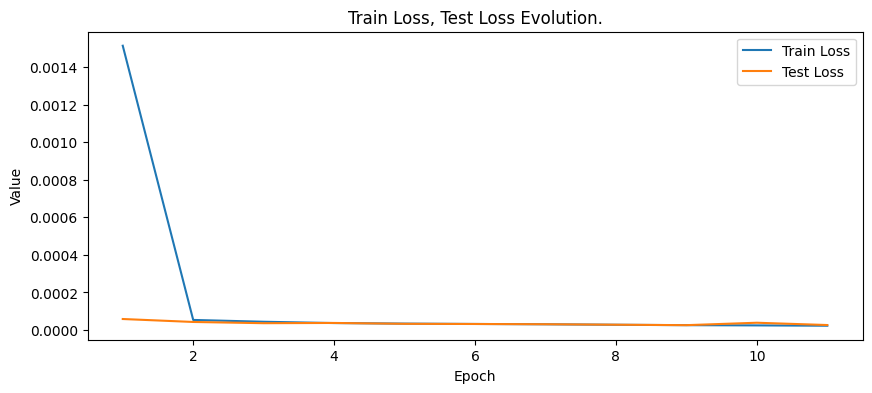

In [56]:
#train_pipeline(model, train_loader, criterion, device, optimizer, n_epochs)
if kaggle and train_mode_waveunet:
    TRAIN(model, criterion, device, optimizer, n_epochs, save_model)
else:
    model = torch.load(path_to_models + save_model)

In [57]:
all_metrics["WaveUNet Model"] = test_pipeline(model, test_loader, criterion, device)

Testing: 100%|██████████| 200/200 [08:59<00:00,  2.70s/batch, PESQ=3.2100, SDR=4.1600, STOI=0.7700, test_loss=0.0000] 

Test Results: Loss: 0.0000 | SDR: 6.2190 | PESQ: 2.7109 | STOI: 0.7031


In [58]:
num_parameters = sum(p.numel() for p in model.parameters() if p.requires_grad)
all_metrics["WaveUNet Model"]["Number of Parameters"] = num_parameters

dummy_input = torch.randn([1, 1, 80000]).to(device)
model.eval()
with torch.no_grad():
    start_time = time.time()
    _ = model(dummy_input)
    end_time = time.time()

all_metrics["WaveUNet Model"]["Inference Time"] = end_time - start_time

with open('model_metrics.pkl', 'wb') as file:
    pickle.dump(all_metrics, file)

### Conv-TasNet

<div style="text-align:center">
    <img src="images/convtastnet.png" alt="Conv-TasNet Architecture" width="600"/>
</div>

Utilise des enchaînement de convolutions pour séparer les sources audio en estimant des masques temporels sur les représentations fréquentielles des signaux mixte.

Les masques représentent ici des filtres appris par le modèle pour séparer les différentes sources dans un signal mixte en attribuant des pondérations à chaque fréquence et temps.

Ces masques sont appliqués au signal mixte pour reconstruire les signaux individuels de chaque source.


In [59]:
class ConvTasnet(nn.Module):
    def __init__(self):
        super().__init__()
        self.convtasnet = torchaudio.models.ConvTasNet(num_sources = 2,
                                                      enc_kernel_size = 8,
                                                       enc_num_feats = 256, 
                                                       msk_kernel_size = 3, 
                                                       msk_num_feats = 128, 
                                                       msk_num_hidden_feats = 256, 
                                                       msk_num_layers = 8, 
                                                       msk_num_stacks = 3, 
                                                      )

    def forward(self, x):
        out = self.convtasnet(x)
        return out[:, 0].unsqueeze(1), out[:, 1].unsqueeze(1)

In [60]:
model = ConvTasnet()

input_mix = torch.randn(3, 1, 80000, requires_grad=True)
output = model(input_mix)
print("Input  :",input_mix.shape)
print("Output :",len(output),output[0].shape,output[1].shape)

Input  : torch.Size([3, 1, 80000])

Output : 2 torch.Size([3, 1, 80000]) torch.Size([3, 1, 80000])


In [61]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = torch.nn.MSELoss()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
n_epochs = 50
model = model.to(device)
save_model = 'model_convtasnet.pt'
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=4, shuffle=False)

In [62]:
print(f'Number of parameters: {sum(p.numel() for p in model.parameters())}')

Number of parameters: 2491441


[--------------------------------------------------]  0.00% ||   00h00m00s    ||   

------------------------------------------------------------|| Remaining Time || Batch Loss || 

||----||   Epoch   ||          Loss          || 

||----||   Time    ||   Train   ||   Test    || 

||  1 || 00h18m06s || 8.5011816 || 3.066e-05 || 

||  2 || 00h18m05s || 3.1838126 || 2.982e-05 || 

||  3 || 00h18m05s || 2.7341252 || 2.810e-05 || 

||  4 || 00h18m06s || 2.4191514 || 2.379e-05 || 

||  5 || 00h18m06s || 2.2286360 || 1.674e-05 || 

||  6 || 00h18m06s || 1.9136810 || 2.025e-05 || 

||  7 || 00h18m06s || 1.7165122 || 1.848e-05 || 

Early stopping triggered


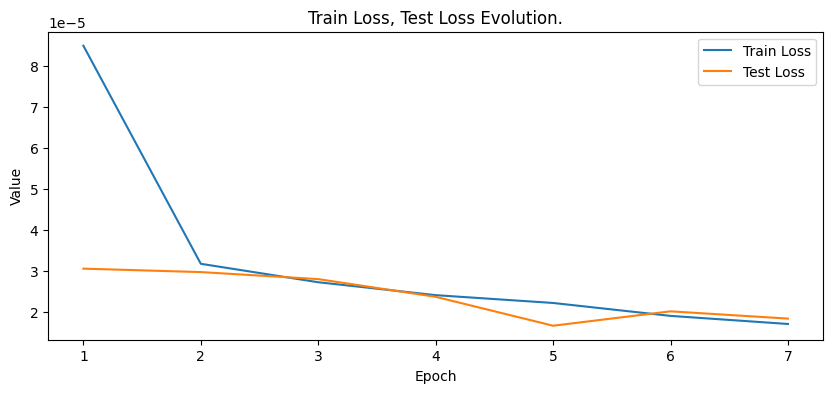

In [63]:
#train_pipeline(model, train_loader, criterion, device, optimizer, n_epochs)
if kaggle and train_mode_convtasnet:
    TRAIN(model, criterion, device, optimizer, n_epochs, save_model)
else:
    model = torch.load(path_to_models + save_model)

In [64]:
all_metrics["ConvTasnet Model"] = test_pipeline(model, test_loader, criterion, device)

Testing: 100%|██████████| 500/500 [11:57<00:00,  1.43s/batch, PESQ=2.5200, SDR=7.8700, STOI=0.7800, test_loss=0.0000] 

Test Results: Loss: 0.0000 | SDR: 7.2848 | PESQ: 2.2560 | STOI: 0.7194


In [65]:
num_parameters = sum(p.numel() for p in model.parameters() if p.requires_grad)
all_metrics["ConvTasnet Model"]["Number of Parameters"] = num_parameters

dummy_input = torch.randn([1, 1, 80000]).to(device)
model.eval()
with torch.no_grad():
    start_time = time.time()
    _ = model(dummy_input)
    end_time = time.time()

all_metrics["ConvTasnet Model"]["Inference Time"] = end_time - start_time

with open('model_metrics.pkl', 'wb') as file:
    pickle.dump(all_metrics, file)

### Hybrid Demucs

<div style="text-align:center">
    <img src="images/hdemucs.jpg" alt="Hybried Demucs Architecture" width="600"/>
</div>

Le Hybrid Demucs est une variante du modèle Demucs (Deep Extractor for Music Sources) qui combine à la fois des convolutions dilatées (DCN) et des réseaux récurrents (RNN).

Combine les avantages des DCN pour l'extraction de caractéristiques à différentes échelles temporelles avec les capacités des RNN à modéliser les dépendances à long terme dans les signaux.

Utilise à la fois des encodeurs temporels et des encodeurs spectrals: il agit donc à la fois sur la forme d'onde et sur le spectrogramme !

In [66]:
class HybridDemucs(nn.Module):
    def __init__(self):
        super().__init__()
        self.hdemucs = torchaudio.models.HDemucs(["mixture", "vocals"], audio_channels=1)

    def forward(self, x):
        out = self.hdemucs(x)
        return out[:, 0], out[:, 1]

In [76]:
model_hdemucs = HybridDemucs()

input_mix = torch.randn(3, 1, 80000, requires_grad=True)
output = model_hdemucs(input_mix)
print("Input  :",input_mix.shape)
print("Output :",len(output),output[0].shape,output[1].shape)

Input  : torch.Size([3, 1, 80000])

Output : 2 torch.Size([3, 1, 80000]) torch.Size([3, 1, 80000])


In [77]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = torch.nn.MSELoss()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
n_epochs = 50
save_model = 'model_hdemucs.pt'
model = model.to(device)

In [78]:
print(f'Number of parameters: {sum(p.numel() for p in model.parameters())}')

Number of parameters: 2491441


[--------------------------------------------------]  0.00% ||   00h00m00s    ||   

------------------------------------------------------------|| Remaining Time || Batch Loss || 

||----||   Epoch   ||          Loss          || 

||----||   Time    ||   Train   ||   Test    || 

||  1 || 00h18m06s || 1.6642403 || 1.438e-05 || 

||  2 || 00h18m06s || 1.4289381 || 1.122e-05 || 

||  3 || 00h18m06s || 1.2337203 || 1.160e-05 || 

||  4 || 00h18m06s || 1.1458437 || 1.032e-05 || 

||  5 || 00h18m06s || 1.0737689 || 1.018e-05 || 

||  6 || 00h18m06s || 1.0228316 || 8.768e-06 || 

||  7 || 00h18m06s || 9.6752123 || 9.674e-06 || 

||  8 || 00h18m06s || 9.3515465 || 8.597e-06 || 

||  9 || 00h18m06s || 9.0431400 || 8.393e-06 || 

|| 10 || 00h18m06s || 8.7519811 || 1.013e-05 || 

|| 11 || 00h18m06s || 8.5500890 || 8.865e-06 || 

Early stopping triggered


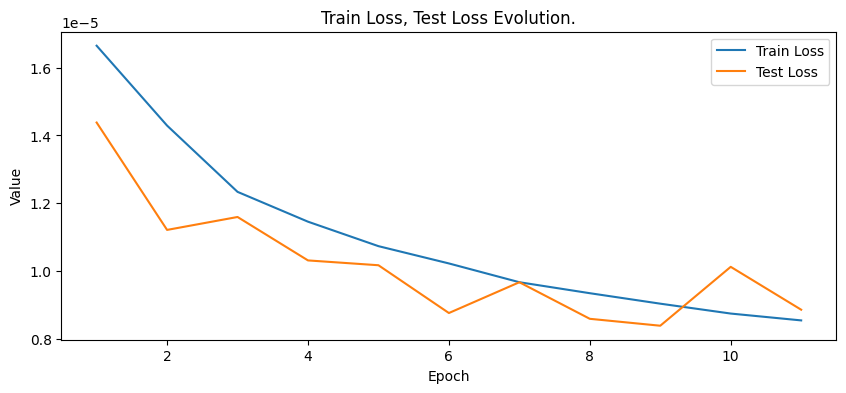

In [79]:
#train_pipeline(model, train_loader, criterion, device, optimizer, n_epochs)
if kaggle and train_mode_hdemucs:
    TRAIN(model, criterion, device, optimizer, n_epochs, save_model)
else:
    model = torch.load(path_to_models + save_model)

In [81]:
all_metrics["HybridDemucs Model"] = test_pipeline(model, test_loader, criterion, device)

Testing: 100%|██████████| 500/500 [11:48<00:00,  1.42s/batch, PESQ=2.4100, SDR=5.5900, STOI=0.8100, test_loss=0.0000] 

Test Results: Loss: 0.0000 | SDR: 5.2308 | PESQ: 2.0586 | STOI: 0.7223


In [83]:
num_parameters = sum(p.numel() for p in model.parameters() if p.requires_grad)
all_metrics["HybridDemucs Model"]["Number of Parameters"] = num_parameters

dummy_input = torch.randn([1, 1, 80000]).to(device)
model.eval()
with torch.no_grad():
    start_time = time.time()
    _ = model(dummy_input)
    end_time = time.time()

all_metrics["HybridDemucs Model"]["Inference Time"] = end_time - start_time

with open('model_metrics.pkl', 'wb') as file:
    pickle.dump(all_metrics, file)

## Summary

In [190]:
with open('model_metrics.pkl', 'rb') as file:
    new_metrics = pickle.load(file)

def format_params_count(count):
    if count < 1000:
        return f"{count}"
    elif count < 1000000:
        return f"{count / 1000:.0f} K"
    else:
        return f"{count / 1000000:.1f} M"
    
def format_inference_time(time):
    return str(int(time*1000)) + " ms"

def format_loss(loss):
    string = "{:.2e}".format(loss)
    return string[:-4] + " " + string[-4:]


for model, metrics in new_metrics.items():
    metrics['Number of Parameters'] = format_params_count(metrics['Number of Parameters'])
    metrics['Inference Time'] = format_inference_time(metrics['Inference Time'])
    metrics['MSE Loss'] = format_loss(metrics['MSE Loss'])

with open('new_metrics.pkl', 'wb') as file:
    pickle.dump(new_metrics, file)

In [191]:
with open('new_metrics.pkl', 'rb') as file:
    new_metrics = pickle.load(file)
print(tabulate(pd.DataFrame(new_metrics).T, headers='keys', tablefmt='grid'))

+--------------------+------------+-----------+---------+----------+------------------------+------------------+
|                    | MSE Loss   |       SDR |    PESQ |     STOI | Number of Parameters   | Inference Time   |
+====================+============+===========+=========+==========+========================+==================+
| Wiener Filter      | 2.18 e-04  | -10.6569  | 2.08805 | 0.80397  | 1                      | 4 ms             |
+--------------------+------------+-----------+---------+----------+------------------------+------------------+
| Butterworth Filter | 2.23 e-04  |  -3.7573  | 1.57805 | 0.895725 | 4                      | 7 ms             |
+--------------------+------------+-----------+---------+----------+------------------------+------------------+
| Dumb Model         | 7.76 e-03  | -55.7942  | 1.20344 | 0.001805 | 400 K                  | 3 ms             |
+--------------------+------------+-----------+---------+----------+------------------------+---

**Wiener** : Préserve le signal et l'intelligibilité, mais un SDR très bas suggère une séparation avec une distorsion significative, il utilise très peu de paramètres et a un temps d'inférence rapide.

**Butterworth** : Similaire à Wiener avec à nouveau un SDR négatif indiquant une séparation relativement pauvre, il utilise plus de paramètres et a un temps d'inférence légèrement plus long.

**WaveUNet** : Affiche un faible MSE Loss, avec le SDR et le PESQ les plus élevés, soulignant sa supériorité dans la préservation du signal et la perception de la qualité audio.

=> nécessite toutefois très un grand nombre de paramètres et a le temps d'inférence le plus long de tous les modèles.

**ConvTasnet** : Performe bien avec un faible MSE Loss, un SDR positif et un PESQ relativement élevé, montrant une séparation efficace des sources et une qualité audio décente.

=> utilise 4 fois moins de paramètres que le WaveUNet et en affichant un temps d'inférence 2 fois plus rapide.

**HybridDemucs** : Performe de manière similaire à ConvTasnet en termes de MSE Loss et SDR, avec un PESQ inférieur mais un STOI plus élevé, indiquant une bien meilleure intelligibilité.

=> utilise le même nombre de paramètres que le ConvTasnet mais avec un temps d'inférence plus court.

In [192]:
small_dataset = AudioDataset(False, train_small_voice, train_small_noise, train_small_mix)

def listen_model(model_name, sample_id=0):
    model = torch.load(model_name)
    
    with torch.no_grad():
        sample = small_dataset[sample_id]
        mixed = sample['mixed'].to(device).unsqueeze(0)
        voice_est, noise_est = model(mixed)
        voice_est = voice_est.squeeze(0).squeeze(0)
        voice_est = np.array(voice_est.cpu())
        
    ipd.display(ipd.Audio(voice_est, rate=8000))

def lisen_weiner(sample_id=0):
    voice_est, _ = wiener_filter(small_dataset[sample_id]['mixed'])
    ipd.display(ipd.Audio(voice_est, rate=8000))

def lisen_butterworth(sample_id=0):
    voice_est, _ = butterworth_filter(small_dataset[sample_id]['mixed'])
    ipd.display(ipd.Audio(voice_est, rate=8000))

In [194]:
print("="*10,"Original Audio".center(20),"="*10)
print()
listen_to_sample(train_small_mix[0])
working_path = path_to_models #"/kaggle/working/"

print("="*10,"Wiener".center(20),"="*10)
print()
lisen_weiner()

print("="*10,"Butterworth".center(20),"="*10)
print()
lisen_butterworth()

print("="*10,"Dumb".center(20),"="*10)
print()
listen_model(working_path + "dumb_model.pt")

print("="*10,"Wave-U-Net".center(20),"="*10)
print()
listen_model(working_path + "model_waveunet.pt")

print("="*10,"Conv-Tas-Net".center(20),"="*10)
print()
listen_model(working_path + "model_convtasnet.pt")

print("="*10,"Hybrid Demucs".center(20),"="*10)
print()
listen_model(working_path + "model_hdemucs.pt")

==========    Original Audio    ==========



==========        Wiener        ==========



==========     Butterworth      ==========



==========         Dumb         ==========



==========      Wave-U-Net      ==========



==========     Conv-Tas-Net     ==========



==========    Hybrid Demucs     ==========

